In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
!pip install jdc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [84]:
import jdc # used fo defining functions for a class in separate cells
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from scipy.interpolate import make_interp_spline
from tqdm import tqdm # for showing progress bar in for loops
from scipy.stats import pearsonr
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

from random import randrange
from pandas import Series
from matplotlib import pyplot


### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [85]:
def func_1(A, B, r, beta):
    return A * (r - r * A - beta * B)

## CCM Algorithm

### Defining CCM Functions

In [86]:
# Computing "Causality" (Correlation between True and Predictions)
class ccm:
    def __init__(self, X, Y, tau=1, E=2, L=500):
        '''
        X: timeseries for variable X that could cause Y
        Y: timeseries for variable Y that could be caused by X
        tau: time lag
        E: shadow manifold embedding dimension
        L: time period/duration to consider (longer = more data)
        We're checking for X -> Y
        '''
        self.X = X
        self.Y = Y
        self.tau = tau
        self.E = E
        self.L = L        
        self.My = self.shadow_manifold(Y) # shadow manifold for Y (we want to know if info from X is in Y)
        self.t_steps, self.dists = self.get_distances(self.My) # for distances between points in manifold    

In [87]:
%%add_to ccm
def shadow_manifold(self, X):
    """
    Given
        X: some time series vector
        tau: lag step
        E: shadow manifold embedding dimension
        L: max time step to consider - 1 (starts from 0)
    Returns
        {t:[t, t-tau, t-2*tau ... t-(E-1)*tau]} = Shadow attractor manifold, dictionary of vectors
    """
    X = X[:L] # make sure we cut at L
    M = {t:[] for t in range((self.E-1) * self.tau, self.L)} # shadow manifold
    for t in range((self.E-1) * self.tau, self.L):
        x_lag = [] # lagged values
        for t2 in range(0, self.E-1 + 1): # get lags, we add 1 to E-1 because we want to include E
            x_lag.append(X[t-t2*self.tau])            
        M[t] = x_lag
    return M

In [88]:
%%add_to ccm

# get pairwise distances between vectors in X
def get_distances(self, Mx):
    """
    Args
        Mx: The shadow manifold from X
    Returns
        t_steps: timesteps
        dists: n x n matrix showing distances of each vector at t_step (rows) from other vectors (columns)
    """

    # we extract the time indices and vectors from the manifold Mx
    # we just want to be safe and convert the dictionary to a tuple (time, vector)
    # to preserve the time inds when we separate them
    t_vec = [(k, v) for k,v in Mx.items()]
    t_steps = np.array([i[0] for i in t_vec])
    vecs = np.array([i[1] for i in t_vec])
    dists = distance.cdist(vecs, vecs)    
    return t_steps, dists

In [89]:
%%add_to ccm

def get_nearest_distances(self, t, t_steps, dists):
    """
    Args:
        t: timestep of vector whose nearest neighbors we want to compute
        t_teps: time steps of all vectors in Mx, output of get_distances()
        dists: distance matrix showing distance of each vector (row) from other vectors (columns). output of get_distances()
        E: embedding dimension of shadow manifold Mx 
    Returns:
        nearest_timesteps: array of timesteps of E+1 vectors that are nearest to vector at time t
        nearest_distances: array of distances corresponding to vectors closest to vector at time t
    """
    t_ind = np.where(t_steps == t) # get the index of time t
    dist_t = dists[t_ind].squeeze() # distances from vector at time t (this is one row)
    
    # get top closest vectors
    nearest_inds = np.argsort(dist_t)[1:self.E+1 + 1] # get indices sorted, we exclude 0 which is distance from itself
    nearest_timesteps = t_steps[nearest_inds] # index column-wise, t_steps are same column and row-wise 
    nearest_distances = dist_t[nearest_inds]  
    
    return nearest_timesteps, nearest_distances


In [90]:
%%add_to ccm
def predict(self, t):
    """
    Args
        t: timestep at Mx to predict Y at same time step
    Returns
        Y_true: the true value of Y at time t
        Y_hat: the predicted value of Y at time t using Mx
    """
    eps = 0.000001 # epsilon minimum distance possible
    t_ind = np.where(self.t_steps == t) # get the index of time t
    dist_t = self.dists[t_ind].squeeze() # distances from vector at time t (this is one row)    
    nearest_timesteps, nearest_distances = self.get_nearest_distances(t, self.t_steps, self.dists)    
    
    # get weights
    u = np.exp(-nearest_distances/np.max([eps, nearest_distances[0]])) # we divide by the closest distance to scale
    w = u / np.sum(u)
    
    # get prediction of X
    X_true = self.X[t] # get corresponding true X
    X_cor = np.array(self.X)[nearest_timesteps] # get corresponding Y to cluster in Mx
    X_hat = (w * X_cor).sum() # get X_hat
    
    return X_true, X_hat
    
    

In [91]:
%%add_to ccm
def causality(self):
    '''
    Args:
        None
    Returns:
        correl: how much self.X causes self.Y. correlation between predicted Y and true Y
    '''

    # run over all timesteps in M
    # X causes Y, we can predict X using My
    # X puts some info into Y that we can use to reverse engineer X from Y        
    X_true_list = []
    X_hat_list = []

    for t in list(self.My.keys()): # for each time step in My
        X_true, X_hat = self.predict(t) # predict X from My
        X_true_list.append(X_true)
        X_hat_list.append(X_hat) 

    x, y = X_true_list, X_hat_list
    r, p = pearsonr(x, y)        

    return r, p


### Functions for Visualizing

In [92]:
%%add_to ccm

def visualize_cross_mapping(self):
    """
    Visualize the shadow manifolds and some cross mappings
    """
    # we want to check cross mapping from Mx to My and My to Mx

    f, axs = plt.subplots(1, 2, figsize=(12, 6))        
    
    for i, ax in zip((0, 1), axs): # i will be used in switching Mx and My in Cross Mapping visualization
        #===============================================
        # Shadow Manifolds Visualization

        X_lag, Y_lag = [], []
        for t in range(1, len(self.X)):
            X_lag.append(X[t-tau])
            Y_lag.append(Y[t-tau])    
        X_t, Y_t = self.X[1:], self.Y[1:] # remove first value

        ax.scatter(X_t, X_lag, s=5, label='$M_x$')
        ax.scatter(Y_t, Y_lag, s=5, label='$M_y$', c='y')

        #===============================================
        # Cross Mapping Visualization

        A, B = [(self.Y, self.X), (self.X, self.Y)][i]
        cm_direction = ['Mx to My', 'My to Mx'][i]

        Ma = self.shadow_manifold(A)
        Mb = self.shadow_manifold(B)

        t_steps_A, dists_A = self.get_distances(Ma) # for distances between points in manifold
        t_steps_B, dists_B = self.get_distances(Mb) # for distances between points in manifold

        # Plot cross mapping for different time steps
        timesteps = list(Ma.keys())
        for t in np.random.choice(timesteps, size=3, replace=False):
            Ma_t = Ma[t]
            near_t_A, near_d_A = self.get_nearest_distances(t, t_steps_A, dists_A)

            for i in range(E+1):
                # points on Ma
                A_t = Ma[near_t_A[i]][0]
                A_lag = Ma[near_t_A[i]][1]
                ax.scatter(A_t, A_lag, c='b', marker='s')

                # corresponding points on Mb
                B_t = Mb[near_t_A[i]][0]
                B_lag = Mb[near_t_A[i]][1]
                ax.scatter(B_t, B_lag, c='r', marker='*', s=50)  

                # connections
                ax.plot([A_t, B_t], [A_lag, B_lag], c='r', linestyle=':') 

        ax.set_title(f'{cm_direction} cross mapping. time lag, tau = {tau}, E = 2')
        ax.legend(prop={'size': 14})

        ax.set_xlabel('$X_t$, $Y_t$', size=15)
        ax.set_ylabel('$X_{t-1}$, $Y_{t-1}$', size=15)               
    plt.show()       

In [93]:
%%add_to ccm
def plot_ccm_correls(self):
    """
    Args
        X: X time series
        Y: Y time series
        tau: time lag
        E: shadow manifold embedding dimension
        L: time duration
    Returns
        None. Just correlation plots
    """
    M = self.shadow_manifold(self.Y) # shadow manifold
    t_steps, dists = self.get_distances(M) # for distances

    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X

    X_My_true, X_My_pred = [], [] # note pred X | My is equivalent to figuring out if X -> Y
    Y_Mx_true, Y_Mx_pred = [], [] # note pred Y | Mx is equivalent to figuring out if Y -> X

    for t in range(tau, L):
        true, pred = ccm_XY.predict(t)
        X_My_true.append(true)
        X_My_pred.append(pred)    

        true, pred = ccm_YX.predict(t)
        Y_Mx_true.append(true)
        Y_Mx_pred.append(pred)        

    # # plot
    figs, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # predicting X from My
    r, p = np.round(pearsonr(X_My_true, X_My_pred), 4)
    
    axs[0].scatter(X_My_true, X_My_pred, s=10)
    axs[0].set_xlabel('$X(t)$ (observed)', size=12)
    axs[0].set_ylabel('$\hat{X}(t)|M_y$ (estimated)', size=12)
    axs[0].set_title(f'tau={tau}, E={E}, L={L}, Correlation coeff = {r}')

    # predicting Y from Mx
    r, p = np.round(pearsonr(Y_Mx_true, Y_Mx_pred), 4)
    
    axs[1].scatter(Y_Mx_true, Y_Mx_pred, s=10)
    axs[1].set_xlabel('$Y(t)$ (observed)', size=12)
    axs[1].set_ylabel('$\hat{Y}(t)|M_x$ (estimated)', size=12)
    axs[1].set_title(f'tau={tau}, E={E}, L={L}, Correlation coeff = {r}')
    plt.show()


In [94]:
df1 = pd.read_csv("/content/drive/MyDrive/Fall_2022/IS_800_Causality_New/Team Project/sea_ice1.csv", index_col='Date', parse_dates=True)
#df1.to_csv("/content/drive/MyDrive/Fall_2022/IS_800_Causality_New/Team Project/sea_ice1.csv")
df1

wind_10m  specific_humidity     LW_down     SW_down  rainfall  \
Date                                                                        
1979-01-01  5.872050           0.786595  184.999071    1.417925  1.089897   
1979-01-02  6.155597           0.756973  182.686318    1.368594  0.923499   
1979-01-03  5.691054           0.777598  186.387764    1.197913  1.218984   
1979-01-04  5.628824           0.819629  191.888081    1.405106  1.783778   
1979-01-05  6.255928           0.869896  190.541890    1.305893  0.995828   
...              ...                ...         ...         ...       ...   
2021-08-27  5.386638           4.563584  305.197693  102.101318  2.559692   
2021-08-28  5.234190           4.366545  302.980530  102.355118  1.951954   
2021-08-29  4.675841           4.300599  302.045685   98.769402  1.618767   
2021-08-30  4.396615           4.272134  300.618896   99.093216  1.643894   
2021-08-31  4.430712           4.206679  298.726013   94.778908  1.605882   

            snowfall         sst         t2m  surface_pressure  sea_ice_extent  
Date                                                                            
1979-01-01  1.031549  273.379711  250.401819        979.401142      14997215.0  
1979-01-02  0.837877  273.376830  250.364683        979.340886      14997215.0  
1979-01-03  1.066028  273.385489  250.452749        983.409060      14997215.0  
1979-01-04  1.448627  273.396461  250.290579        983.557055      14922219.0  
1979-01-05  0.776768  273.404602  250.895886        978.020927      14922219.0  
...              ...         ...         ...               ...             ...  
2021-08-27  0.388835  278.514526  278.483246        980.477173       5279000.0  
2021-08-28  0.489219  278.515076  277.969543        981.036499       5268000.0  
2021-08-29  0.333258  278.482941  277.669586        981.798767       5189000.0  
2021-08-30  0.335707  278.492828  277.581635        983.147156       5157000.0  
2021-08-31  0.265257  278.460632  277.484070        984.148193       5199000.0  

[15584 rows x 10 columns]

##Data Visualization##

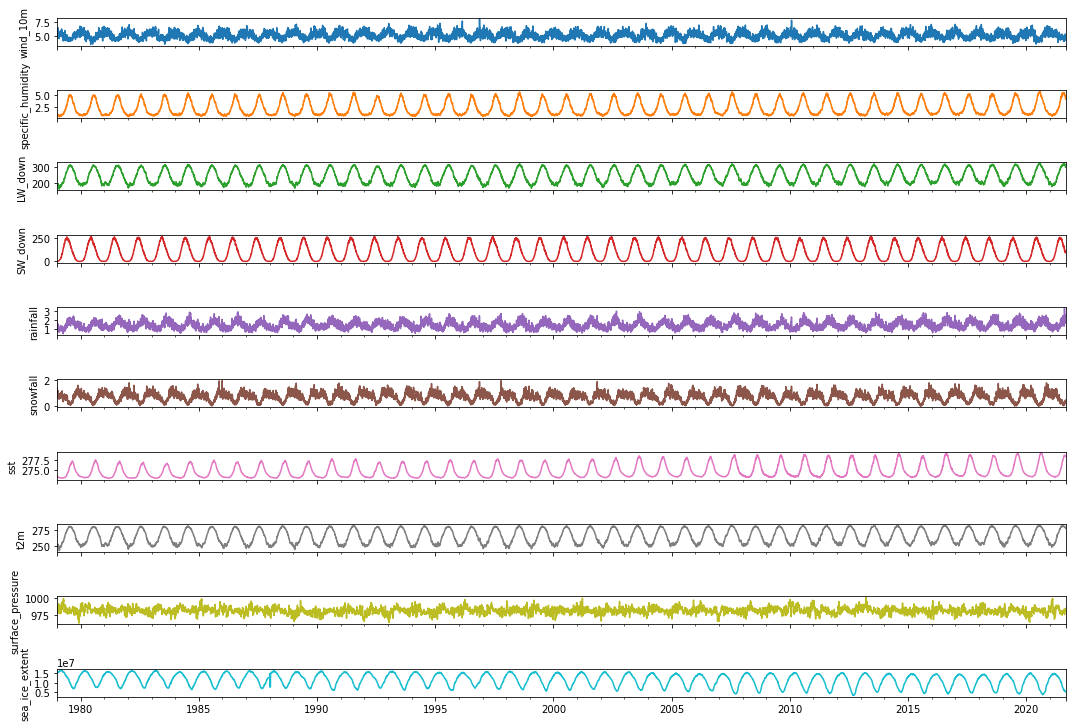

In [95]:
fig,ax = plt.subplots(10, figsize=(15,10), sharex=True)
plot_cols = ['wind_10m',	'specific_humidity',	'LW_down',	'SW_down',	'rainfall',	'snowfall',	'sst',	't2m',	'surface_pressure',	'sea_ice_extent']
#plot_cols = ['wind_10m',	'SW_down',	'rainfall',	'snowfall',	'sst',	'sea_ice_extent']
df1[plot_cols].plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)): 
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

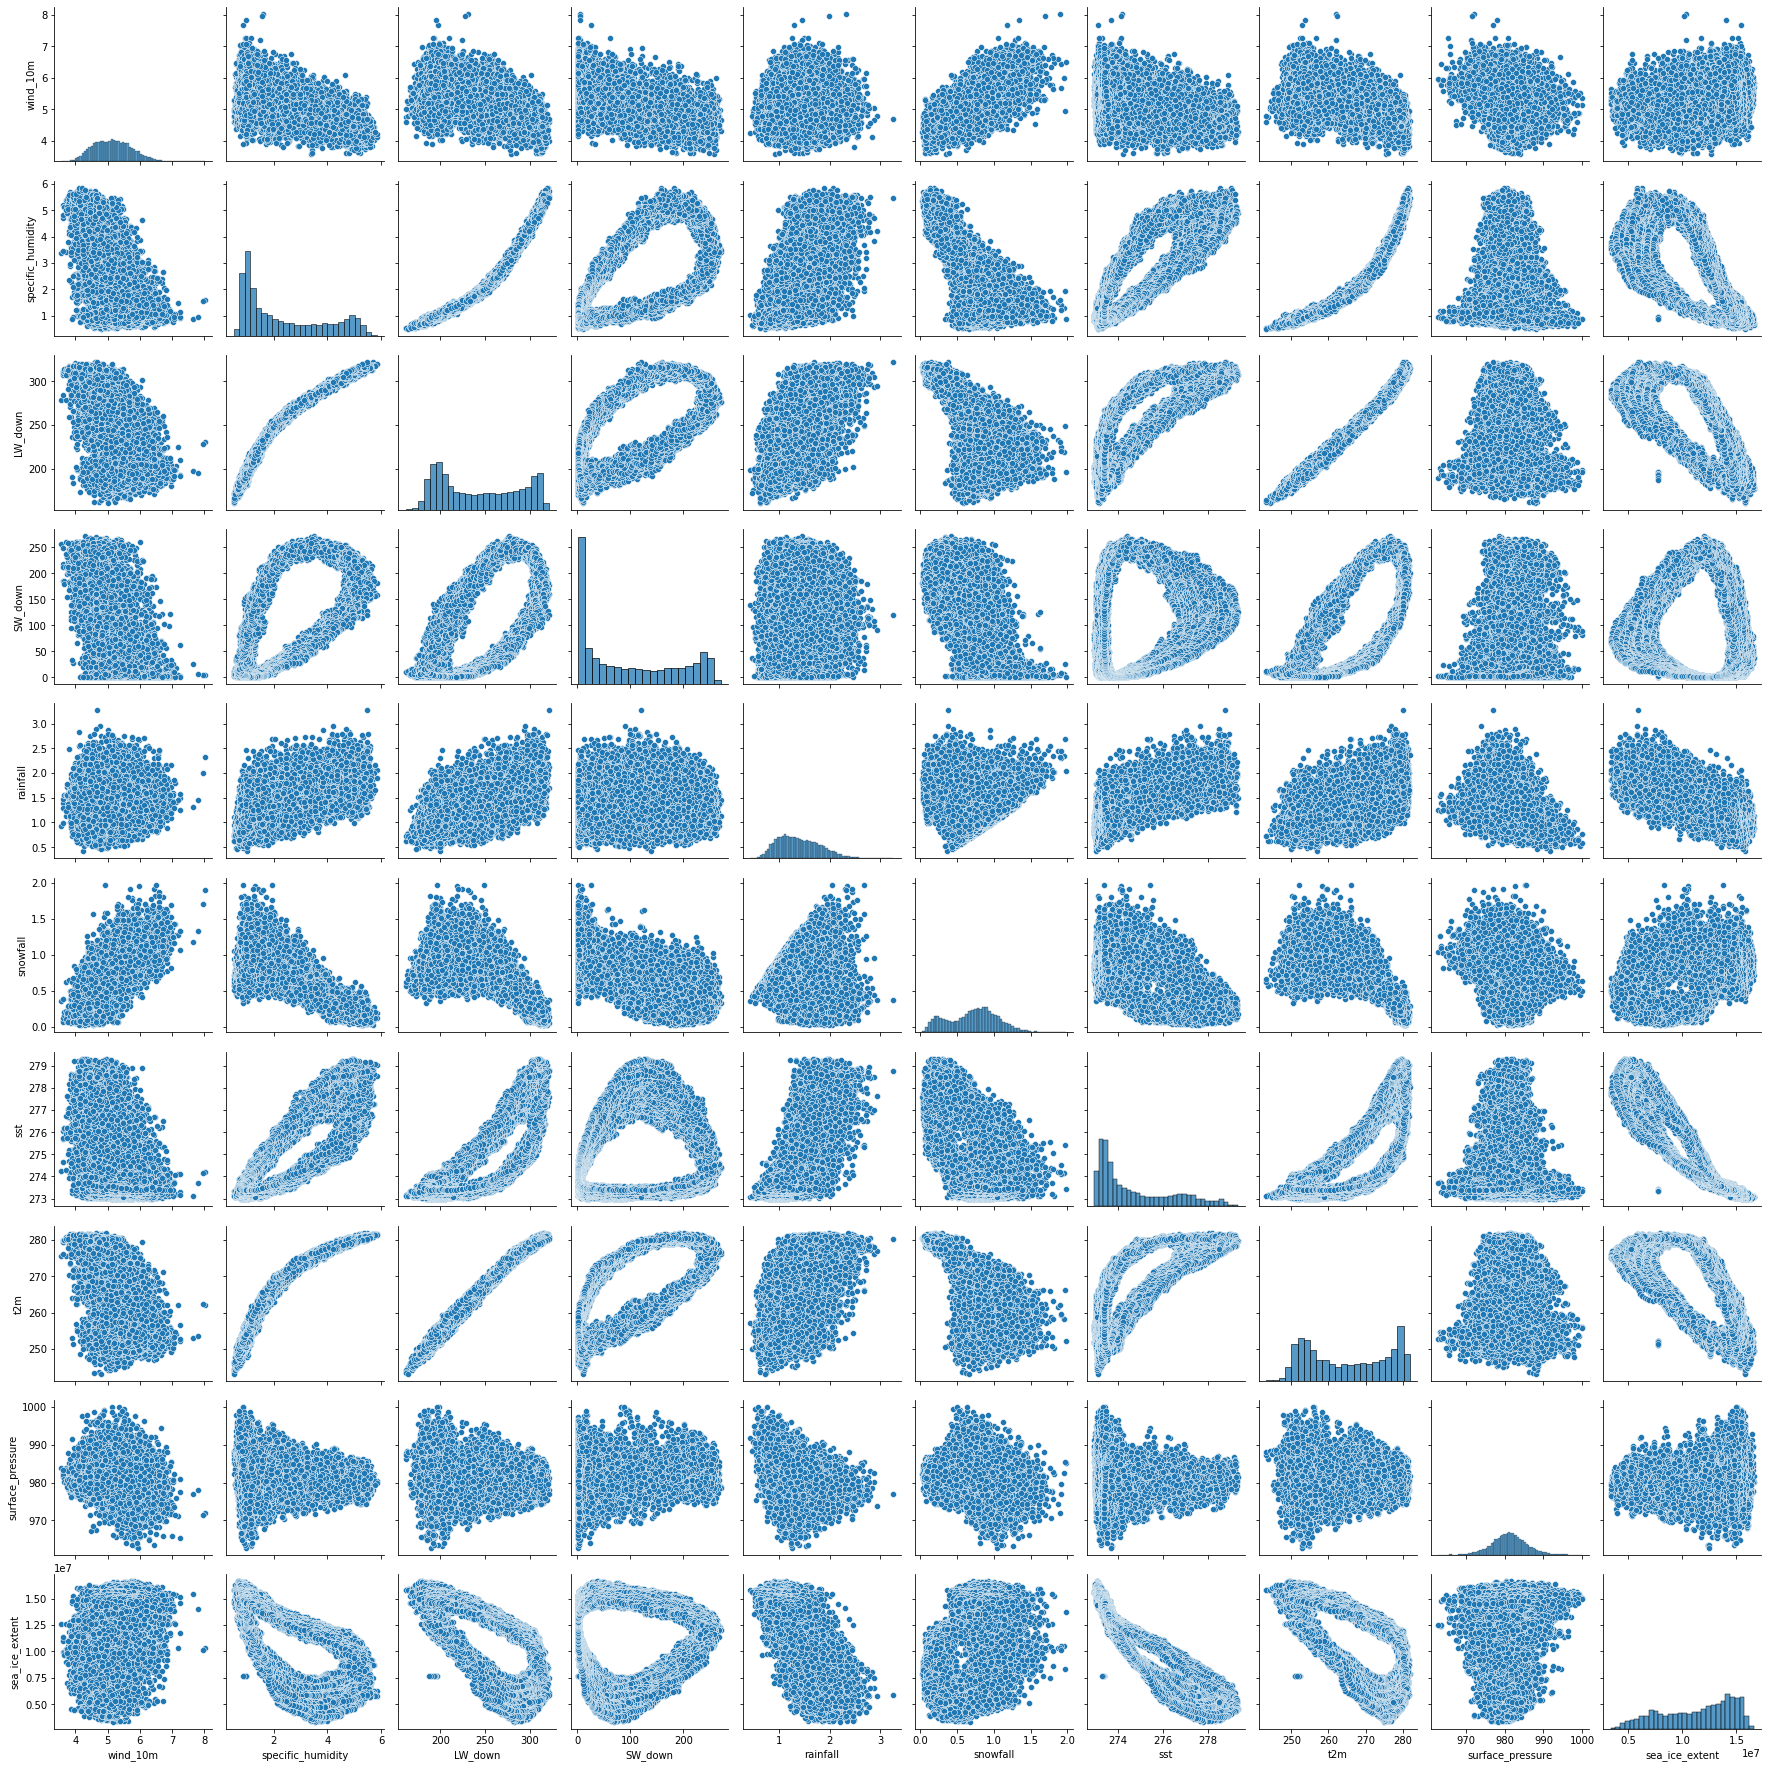

In [96]:
sns.pairplot(df1)

In [97]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0,1))
# array = scaler.fit_transform(np.array(df).reshape(-1,1))

#Data Pre-processing#



1.   Remove Trend and Seasonality in data
2.   Normalize data
3.   Research other time series pre-processing steps



<Figure size 1152x648 with 0 Axes>

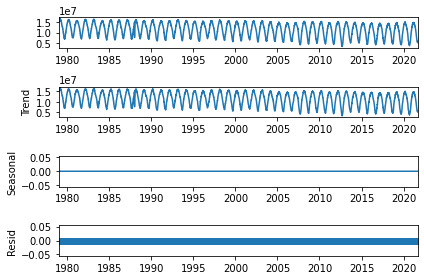

In [98]:
plt.figure(figsize=(16,9))
#series = [i+randrange(10) for i in range(1,100)]
df2 = df1[['sea_ice_extent']]
result = seasonal_decompose(df2, model='additive', period=1)

result.plot()

pyplot.show()

In [99]:
# copy the data
df2 = df1.copy()
  
# apply normalization techniques
for column in df2.columns:
    df2[column] = (df2[column] - df2[column].min()) / (df2[column].max() - df2[column].min())    
  
# view normalized data
print(df2)

            wind_10m  specific_humidity   LW_down   SW_down  rainfall  \
Date                                                                    
1979-01-01  0.517383           0.051057  0.147348  0.002653  0.235034   
1979-01-02  0.580918           0.045493  0.132914  0.002471  0.176469   
1979-01-03  0.476827           0.049367  0.156016  0.001841  0.280466   
1979-01-04  0.462883           0.057262  0.190345  0.002606  0.479249   
1979-01-05  0.603399           0.066704  0.181943  0.002240  0.201925   
...              ...                ...       ...       ...       ...   
2021-08-27  0.408616           0.760484  0.897556  0.374432  0.752336   
2021-08-28  0.374456           0.723474  0.883718  0.375369  0.538440   
2021-08-29  0.249346           0.711088  0.877884  0.362128  0.421172   
2021-08-30  0.186779           0.705741  0.868978  0.363324  0.430016   
2021-08-31  0.194420           0.693447  0.857164  0.347393  0.416637   

            snowfall       sst       t2m  surface_

In [100]:
df2.index.rename('date', inplace=True)
df2

wind_10m  specific_humidity   LW_down   SW_down  rainfall  \
date                                                                    
1979-01-01  0.517383           0.051057  0.147348  0.002653  0.235034   
1979-01-02  0.580918           0.045493  0.132914  0.002471  0.176469   
1979-01-03  0.476827           0.049367  0.156016  0.001841  0.280466   
1979-01-04  0.462883           0.057262  0.190345  0.002606  0.479249   
1979-01-05  0.603399           0.066704  0.181943  0.002240  0.201925   
...              ...                ...       ...       ...       ...   
2021-08-27  0.408616           0.760484  0.897556  0.374432  0.752336   
2021-08-28  0.374456           0.723474  0.883718  0.375369  0.538440   
2021-08-29  0.249346           0.711088  0.877884  0.362128  0.421172   
2021-08-30  0.186779           0.705741  0.868978  0.363324  0.430016   
2021-08-31  0.194420           0.693447  0.857164  0.347393  0.416637   

            snowfall       sst       t2m  surface_pressure  sea_ice_extent  
date                                                                        
1979-01-01  0.517164  0.064850  0.184614          0.447048        0.876826  
1979-01-02  0.418025  0.064395  0.183652          0.445427        0.876826  
1979-01-03  0.534813  0.065762  0.185933          0.554901        0.876826  
1979-01-04  0.730662  0.067494  0.181732          0.558884        0.871185  
1979-01-05  0.386744  0.068779  0.197414          0.409907        0.871185  
...              ...       ...       ...               ...             ...  
2021-08-27  0.188165  0.875521  0.912109          0.476004        0.145853  
2021-08-28  0.239551  0.875608  0.898801          0.491056        0.145025  
2021-08-29  0.159716  0.870535  0.891030          0.511568        0.139083  
2021-08-30  0.160970  0.872096  0.888751          0.547853        0.136676  
2021-08-31  0.124907  0.867013  0.886224          0.574791        0.139835  

[15584 rows x 10 columns]

In [101]:
df3 = df2.loc['2015-01-01':'2021-08-31']

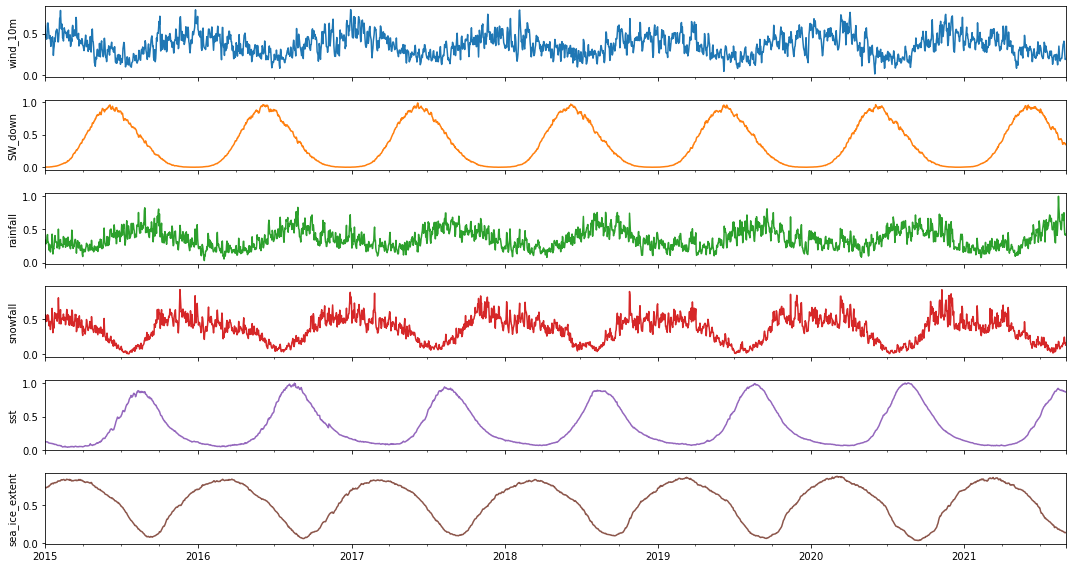

In [102]:
fig,ax = plt.subplots(6, figsize=(15,8), sharex=True)
#plot_cols = ['wind_10m',	'specific_humidity',	'LW_down',	'SW_down',	'rainfall',	'snowfall',	'sst',	't2m',	'surface_pressure',	'sea_ice_extent']
plot_cols = ['wind_10m',	'SW_down',	'rainfall',	'snowfall',	'sst',	'sea_ice_extent']
df3[plot_cols].plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)): 
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

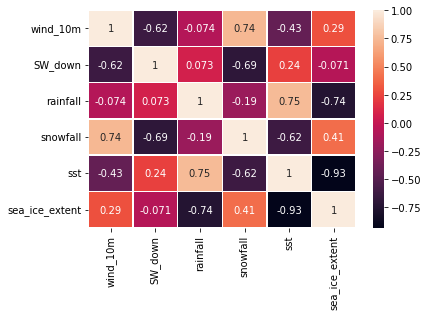

In [103]:

df3 = df3[['wind_10m',	'SW_down',	'rainfall',	'snowfall',	'sst',	'sea_ice_extent']]
corr_df1_norm = df3.corr(method='pearson')

# Customize the heatmap of the corr_meat correlation matrix
sns.heatmap(corr_df1_norm,
           annot=True,
           linewidths=0.4,
           annot_kws={'size': 10});

plt.xticks(rotation=90);
plt.yticks(rotation=0);

In [104]:
df = df3[['sea_ice_extent', 'snowfall']]
df

sea_ice_extent  snowfall
date                                
2015-01-01        0.732087  0.461179
2015-01-02        0.736023  0.558980
2015-01-03        0.735047  0.522368
2015-01-04        0.730439  0.511106
2015-01-05        0.735267  0.462178
...                    ...       ...
2021-08-27        0.145853  0.188165
2021-08-28        0.145025  0.239551
2021-08-29        0.139083  0.159716
2021-08-30        0.136676  0.160970
2021-08-31        0.139835  0.124907

[2435 rows x 2 columns]

In [105]:
def make_plots(df, dt_name, val1_name, val2_name):
    # drop nulls
    df = df[[dt_name, val1_name, val2_name]].dropna()
    
    # plot
    f, ax = plt.subplots(figsize=(15, 6))
    df.plot(x=dt_name, y=val1_name, label=None, ax=ax)
    ax.set_ylabel(val1_name)
    ax2 = ax.twinx()
    df.plot(x=dt_name, y=val2_name, label=None, ax=ax2, c='orange')
    ax2.set_ylabel(val2_name)    
#     ax.figure.legend()        
    plt.title(f"{val1_name} and {val2_name}, correlation coefficient: {r}")
    plt.tight_layout()
    plt.show()

#Model Application

*   Baseline Models: Granger Causality, Temporal Causal Discovery Framework(TCDF)
*   Our Model: Convergence Cross Mapping



#*Granger Causality Test*#

#*Temporal Causal Discovery Framework(TCDF)*#

#*CCM*#

##snowfall and sea_ice_extent in the artic regions##	
We investigate the bi-directional effects of the quantity of snow fall on the content of sea ice for the period between 1979 and 2021. 

Do we expect these two to be causally linked?

In [106]:
df['date'] = df.index

In [107]:
df.columns

Index(['sea_ice_extent', 'snowfall', 'date'], dtype='object')

In [108]:
df

sea_ice_extent  snowfall       date
date                                           
2015-01-01        0.732087  0.461179 2015-01-01
2015-01-02        0.736023  0.558980 2015-01-02
2015-01-03        0.735047  0.522368 2015-01-03
2015-01-04        0.730439  0.511106 2015-01-04
2015-01-05        0.735267  0.462178 2015-01-05
...                    ...       ...        ...
2021-08-27        0.145853  0.188165 2021-08-27
2021-08-28        0.145025  0.239551 2021-08-28
2021-08-29        0.139083  0.159716 2021-08-29
2021-08-30        0.136676  0.160970 2021-08-30
2021-08-31        0.139835  0.124907 2021-08-31

[2435 rows x 3 columns]

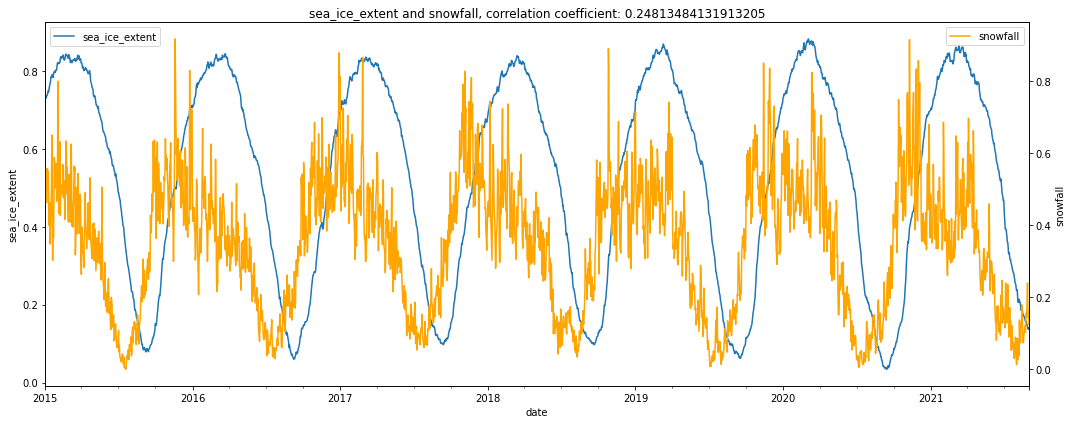

In [109]:
#df['date'] = range(1999, 2010)
make_plots(df, 'date', 'sea_ice_extent', 'snowfall')

X->Y r 0.69 p value 0.0
Y->X r 0.34 p value 0.0


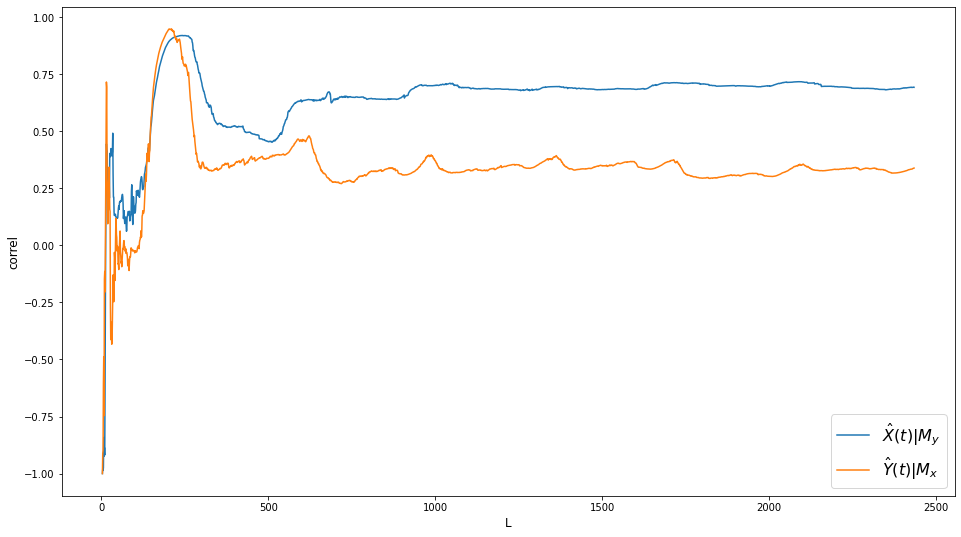

In [110]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['sea_ice_extent'].values
X = df['snowfall'].values

# Looking at "convergence"
L_range = range(3, L+1, 1) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(16,9))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16})  

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

##wind_10m vs sea_ice_extent##

###Here we investigate the effects of wind speed at 10m above sea level to the content of sea ice###

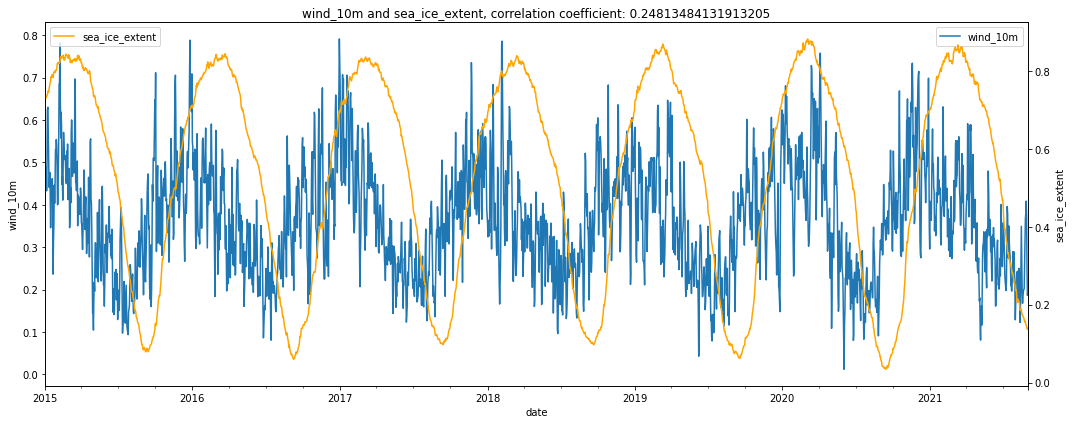

In [111]:
df = df3[['wind_10m', 'sea_ice_extent']]
df['date'] = df.index
make_plots(df, 'date', 'wind_10m', 'sea_ice_extent')

X->Y r 0.12 p value 0.0
Y->X r 0.4 p value 0.0


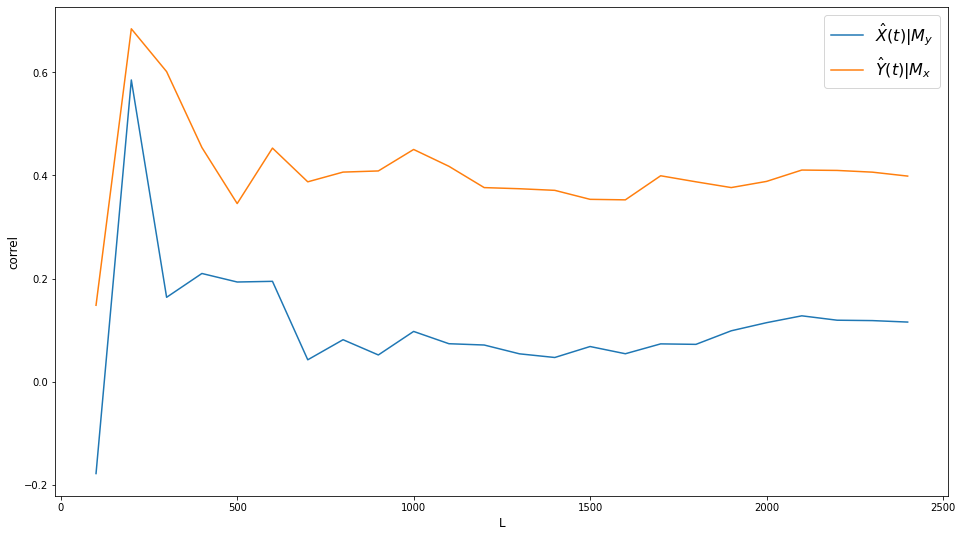

In [112]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['wind_10m'].values
X = df['sea_ice_extent'].values

# Looking at "convergence"
L_range = range(100, L+1, 100) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(16,9))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16})   

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 4))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 4))

#**sw_down vs sea_ice_extent**#

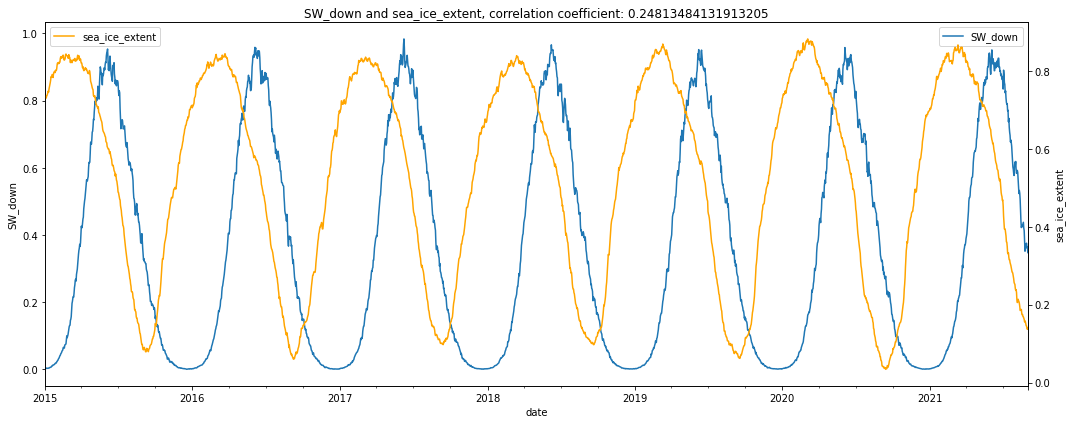

In [113]:
df = df3[['SW_down', 'sea_ice_extent']]
df['date'] = df.index
make_plots(df, 'date', 'SW_down', 'sea_ice_extent')

X->Y r 0.6 p value 0.0
Y->X r 0.7 p value 0.0


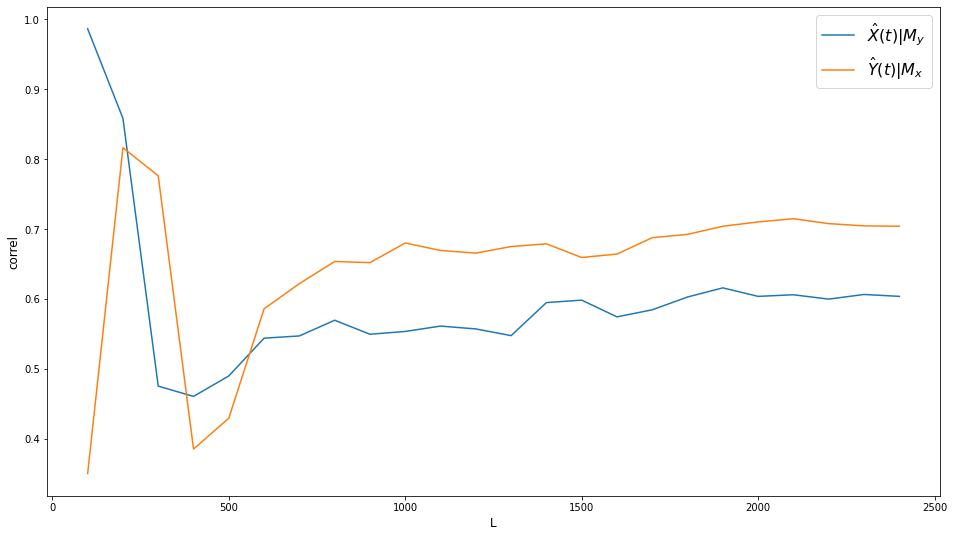

In [114]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['SW_down'].values
X = df['sea_ice_extent'].values

# Looking at "convergence"
L_range = range(100, L+1, 100) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(16,9))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16}) 

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

#### SST vs sea_ice_extent

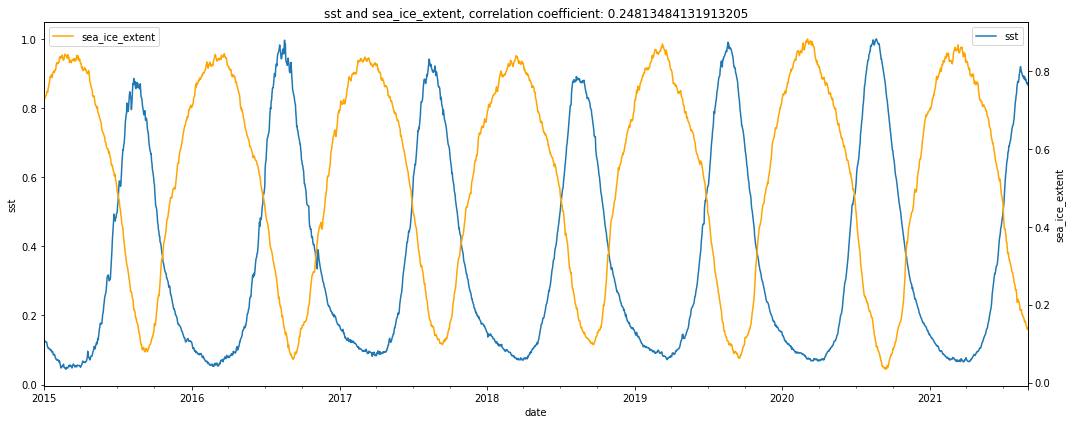

In [115]:
df = df3[['sst', 'sea_ice_extent']]
df['date'] = df.index
make_plots(df, 'date', 'sst', 'sea_ice_extent')

X->Y r 0.98 p value 0.0
Y->X r 0.97 p value 0.0


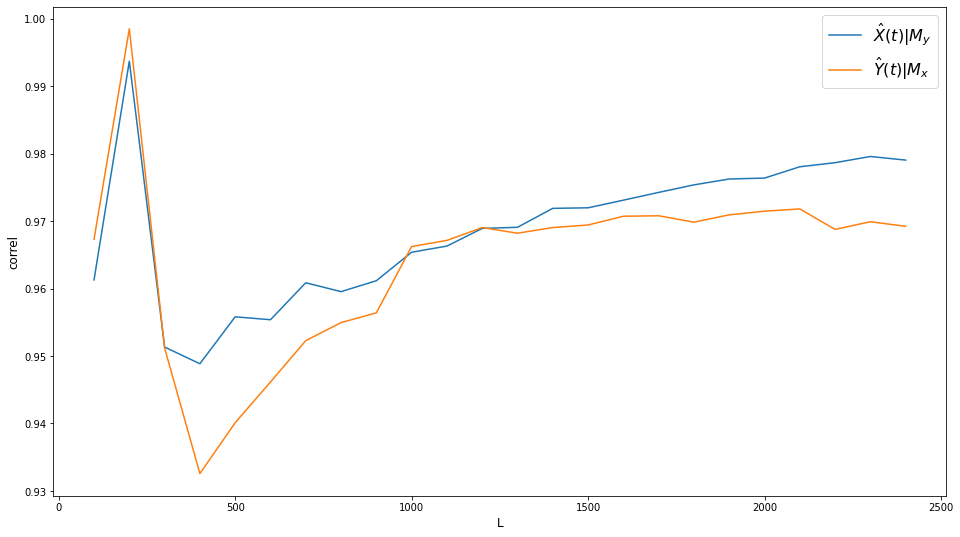

In [116]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['sst'].values
X = df['sea_ice_extent'].values

# Looking at "convergence"
L_range = range(100, L+1, 100) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(16,9))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16}) 

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))